In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import sys
import json
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Optional, Tuple, Any
import pandas as pd
from joblib import Parallel, delayed
import numpy as np

In [99]:
def parse_bpp_from_experiment(exp_name: str) -> Optional[int]:
    parts = exp_name.split("_")
    
    if parts[0] == "1" and parts[1] == '1':
        return 1
    elif parts[0] == "1" and parts[1] == '3':
        return 3
    elif parts[0] == "3" and parts[1] == '3' and "stegformer" in exp_name.lower():
        return 3
    elif parts[0] == "3" and parts[1] == '3':
        return 6
    elif parts[0] == "15" and parts[1] == '2':
        return 8
    else:
        print(f"[WARN] Could not parse bpp from experiment name: {exp_name}")
        return None

def find_distance_files(dist_dir: Path, metric: str, mode: str) -> Dict[Tuple[str, str], Path]:
    """
    Return mapping {(condition, pair_type) -> file_path} if exists.
    Supports offline & online suffixes.
    Condition: OO, OW, WW
    Pair type: genuine, impostor
    """
    if mode == 'online':
        patterns = {
            ("OO", "genuine"):   [f"{metric}_genuine_distances_baseline_online.csv"],
            ("OO", "impostor"):  [f"{metric}_impostor_distances_baseline_online.csv"],
            ("OW", "genuine"):   [f"{metric}_genuine_distances_watermarked_online.csv"],
            ("OW", "impostor"):  [f"{metric}_impostor_distances_watermarked_online.csv"],
            ("WW", "genuine"):   [f"{metric}_genuine_distances_watermarked_both_online.csv"],
            ("WW", "impostor"):  [f"{metric}_impostor_distances_watermarked_both_online.csv"],
        }
    else:
        patterns = {
            ("OO", "genuine"):   [f"{metric}_genuine_distances_baseline.csv"],
            ("OO", "impostor"):  [f"{metric}_impostor_distances_baseline.csv"],
            ("OW", "genuine"):   [f"{metric}_genuine_distances_watermarked.csv"],
            ("OW", "impostor"):  [f"{metric}_impostor_distances_watermarked.csv"],
            ("WW", "genuine"):   [f"{metric}_genuine_distances_watermarked_both.csv"],
            ("WW", "impostor"):  [f"{metric}_impostor_distances_watermarked_both.csv"],
        }
    out = {}
    for key, candidates in patterns.items():
        for name in candidates:
            p = dist_dir / name
            if p.is_file():
                out[key] = p
                break
    return out


def read_distance_column(csv_path: Path) -> np.ndarray:
    """
    Reads a CSV that may have header or multiple columns and returns a 1D float array.
    Prefers columns named ['distance','dist','score']; otherwise picks the column with most numeric values.
    """
    df = pd.read_csv(csv_path, sep=None, engine="python")
    if df.shape[1] == 1:
        s = pd.to_numeric(df.iloc[:, 0], errors="coerce")
        return s.dropna().to_numpy(dtype=float)
    preferred = [c for c in df.columns if str(c).strip().lower() in {"distance", "dist", "score"}]
    if preferred:
        s = pd.to_numeric(df[preferred[0]], errors="coerce")
        return s.dropna().to_numpy(dtype=float)
    # fallback: pick the numerically richest column
    best = None; best_count = -1
    for c in df.columns:
        s = pd.to_numeric(df[c], errors="coerce")
        count = s.notna().sum()
        if count > best_count:
            best_count = count; best = s
    return best.dropna().to_numpy(dtype=float)


def collect_records(root: Path, watermark: str, recognizer: str, metric: str,
                    train_filter: Optional[str] = None,
                    test_filter: Optional[List[str]] = None,
                    mode = str) -> List[Dict]:
    """
    Walks the directory tree and collects long-form records.
    Expected layout:
      root / <watermark> / <experiment> / <train_dataset> / <test_dataset> / <recognizer> / distances / *.csv
    """
    records: List[Dict] = []

    algo_dir = root / watermark
    if not algo_dir.is_dir():
        raise FileNotFoundError(f"Algorithm dir not found: {algo_dir}")

    for exp_dir in sorted([p for p in algo_dir.iterdir() if p.is_dir()]):
        bpp = parse_bpp_from_experiment(exp_dir.name)
        # If bpp can't be inferred, skip (avoid polluting stats)
        if bpp is None:
            continue

        # <train_dataset> dirs
        for train_dir in sorted([p for p in exp_dir.iterdir() if p.is_dir()]):
            train_dataset = train_dir.name
            if train_filter and train_dataset.lower() != train_filter.lower():
                continue

            # <test_dataset> dirs
            for test_dir in sorted([p for p in train_dir.iterdir() if p.is_dir()]):
                test_dataset = test_dir.name
                if test_filter and test_dataset not in test_filter:
                    continue

                recog_dir = test_dir / recognizer / "distances"
                if not recog_dir.is_dir():
                    # some structures store distances directly under recognizer
                    recog_dir = test_dir / recognizer
                if not recog_dir.is_dir():
                    # Nothing to do
                    continue

                files = find_distance_files(recog_dir, metric=metric, mode=mode)
                if not files:
                    continue

                for (condition, pair_type), csv_path in files.items():
                    try:
                        arr = read_distance_column(csv_path)
                        if arr.size == 0:
                            continue
                        for val in arr:
                            records.append({
                                "watermark": watermark,
                                "recognizer": recognizer,
                                "metric": metric,
                                "train_dataset": train_dataset,
                                "test_dataset": test_dataset,
                                "bpp": int(bpp),
                                "condition": condition,    # OO, OW, WW
                                "pair_type": pair_type,    # genuine, impostor
                                "distance": float(val),
                                "experiment": exp_dir.name,
                                "path": str(csv_path)
                            })
                    except Exception as e:
                        print(f"[WARN] Failed reading {csv_path}: {e}")
                        continue
    return records

def calcular_threshold_por_bpp_y_condition(
    df_dataset: pd.DataFrame, 
    far_list: list[float], 
    n_jobs: int = -1
) -> dict:
    """
    Calcula el umbral (Threshold) para una lista de Tasas de Falsa Aceptación (FAR)
    específicas para cada combinación de 'bpp' y 'condition' en el DataFrame de un 
    único dataset, utilizando procesamiento paralelo.

    Args:
        df_dataset (pd.DataFrame): El DataFrame de entrada (ya filtrado para un solo dataset).
        far_list (list[float]): Lista de valores FAR deseados (e.g., [0.001, 0.0001]).
        n_jobs (int): Número de trabajos paralelos a usar. -1 usa todos los núcleos.

    Returns:
        dict: Un diccionario anidado. La clave exterior es la tupla ('bpp', 'condition'), 
              la clave interior es el FAR, y el valor es el Threshold o el mensaje de error.
    """
    
    # 1. Preparación de los datos: Filtrar solo pares 'impostor'
    columnas_necesarias = ['bpp', 'condition', 'pair_type', 'distance']
    df_impostor = df_dataset[df_dataset['pair_type'] == 'impostor'][columnas_necesarias].copy()
    
    if df_impostor.empty:
        return {"Error": "El DataFrame no contiene pares de tipo 'impostor'."}
    
    # 2. Agrupar por 'bpp' y 'condition'
    # Las claves del diccionario serán tuplas (bpp, condition)
    grupos_combinados = {
        (bpp, condition): group['distance'].sort_values().values
        for (bpp, condition), group in df_impostor.groupby(['bpp', 'condition'])
    }
    
    # 3. Definir la función de trabajo (la lógica de cálculo del umbral no cambia)
    def _calcular_umbral(group_key: tuple, distancias: np.ndarray, far_list: list[float]) -> dict:
        """Calcula los umbrales para una única combinación de BPP y Condition."""
        bpp_value, condition_value = group_key
        resultados_combinacion = {}
        total_impostores = len(distancias)
        
        for far in far_list:
            far_prop = far * 100
            
            # --- Criterio de Suficiencia de Datos ---
            min_impostores_necesarios = int(1 / far_prop)

            if total_impostores < min_impostores_necesarios:
                 resultados_combinacion[far] = (
                    f"No puedo calcular un FAR de {far:.4g}%."
                    f" Necesito al menos {min_impostores_necesarios:,} impostores."
                    f" Solo tengo {total_impostores:,} (para BPP={bpp_value}, Cond={condition_value})."
                )
                 continue
            
            # --- Cálculo del Umbral ---
            threshold = np.percentile(distancias, far_prop)

            resultados_combinacion[far] = threshold
            
        return {group_key: resultados_combinacion}

    # 4. Ejecutar la función de trabajo en paralelo
    resultados_paralelos = Parallel(n_jobs=n_jobs)(
        delayed(_calcular_umbral)(group_key, dists, far_list)
        for group_key, dists in grupos_combinados.items()
    )
    
    # 5. Combinar los resultados
    resultados_finales = {}
    for res in resultados_paralelos:
        if res:
            resultados_finales.update(res)
        
    return resultados_finales

def calcular_threshold_por_bpp(
    df_dataset: pd.DataFrame, 
    far_list: list[float], 
    n_jobs: int = -1
) -> dict:
    """
    Calcula el umbral (Threshold) para una lista de Tasas de Falsa Aceptación (FAR)
    específicas para cada nivel de 'bpp' en el DataFrame de un único dataset, 
    utilizando procesamiento paralelo.

    Args:
        df_dataset (pd.DataFrame): El DataFrame de entrada (ya filtrado para un solo dataset).
        far_list (list[float]): Lista de valores FAR deseados (e.g., [0.001, 0.0001]).
        n_jobs (int): Número de trabajos paralelos a usar. -1 usa todos los núcleos.

    Returns:
        dict: Un diccionario anidado. La clave exterior es el valor 'bpp', 
              la clave interior es el FAR, y el valor es el Threshold o 
              el mensaje de error ("No puedo calcular...").
    """
    
    # 1. Preparación de los datos: Filtrar solo pares 'impostor'
    # Solo necesitamos 'bpp', 'pair_type' y 'distance'
    df_impostor = df_dataset[df_dataset['pair_type'] == 'impostor'][['bpp', 'distance']].copy()
    
    if df_impostor.empty:
        return {"Error": "El DataFrame no contiene pares de tipo 'impostor'."}
    
    # 2. Agrupar por 'bpp'
    grupos_bpp = {
        bpp: group['distance'].sort_values().values
        for bpp, group in df_impostor.groupby('bpp')
    }
    
    # 3. Definir la función de trabajo (igual que antes, pero el nombre del grupo es 'bpp')
    def _calcular_umbral(bpp_value: int, distancias: np.ndarray, far_list: list[float]) -> dict:
        """Calcula los umbrales para un único valor de BPP."""
        resultados_bpp = {}
        total_impostores = len(distancias)
        
        for far in far_list:
            far_prop = far * 100
            
            # --- Criterio de Suficiencia de Datos (Min. 1 comparación por cada 1/FAR) ---
            min_impostores_necesarios = int(1 / far_prop)

            if total_impostores < min_impostores_necesarios:
                 resultados_bpp[far] = (
                    f"No puedo calcular un FAR de {far:.4g}%."
                    f" Necesito al menos {min_impostores_necesarios:,} comparaciones de impostores,"
                    f" pero solo tengo {total_impostores:,} (para BPP={bpp_value})."
                )
                 continue
            
            # --- Cálculo del Umbral ---
            threshold = np.percentile(distancias, far_prop)


            resultados_bpp[far] = threshold
            
        return {bpp_value: resultados_bpp}

    # 4. Ejecutar la función de trabajo en paralelo
    resultados_paralelos = Parallel(n_jobs=n_jobs)(
        delayed(_calcular_umbral)(bpp, dists, far_list)
        for bpp, dists in grupos_bpp.items()
    )
    
    # 5. Combinar los resultados de los diccionarios
    resultados_finales = {}
    for res in resultados_paralelos:
        if res: # Evitar agregar resultados vacíos si hay un error general
            resultados_finales.update(res)
        
    return resultados_finales

def calcular_tar(df_genuine: pd.DataFrame, threshold: float) -> float:
    """
    Calcula la Tasa de Aceptación Verdadera (TAR) para un DataFrame de pares 'genuine'
    dado un umbral de distancia.
    
    Args:
        df_genuine (pd.DataFrame): DataFrame que contiene solo pares 'genuine'.
        threshold (float): El umbral de distancia (distancia <= threshold se considera 'aceptado').
        
    Returns:
        float: El TAR en porcentaje.
    """
    if df_genuine.empty:
        return 0.0
    
    # Contamos cuántas distancias genuinas son menores o iguales al umbral (Aceptación Verdadera)
    true_accepts = (df_genuine['distance'] <= threshold).sum()
    
    # Calculamos el TAR
    tar_rate = (true_accepts / len(df_genuine)) * 100.0
    return tar_rate

# ----------------- PARTE 2: Función de Plotting Principal -----------------

def plot_tar_vs_bpp(
    df_long: pd.DataFrame, 
    threshold_dict: Dict[str, Any], 
    dataset_name: str, 
    far_list: List[float]
):
    """
    Calcula el TAR para los umbrales dados y genera un gráfico por cada FAR, 
    mostrando TAR vs BPP para cada condición (OO, OW, WW).
    
    Args:
        df_long (pd.DataFrame): El DataFrame original con todos los datos.
        threshold_dict (Dict): El diccionario de umbrales calculado (e.g., {'CFD': {...}}).
        dataset_name (str): El nombre del dataset a graficar (e.g., 'CFD').
        far_list (List[float]): Lista de valores FAR para generar un plot por cada uno.
    """
    
    sns.set_style("whitegrid")
    
    # 1. Preparar el subconjunto de datos 'genuine' para el dataset objetivo
    # Solo necesitamos pares 'genuine' para calcular el TAR.
    df_genuine_full = df_long[
        (df_long['test_dataset'] == dataset_name) & 
        (df_long['pair_type'] == 'genuine')
    ].copy()

    if df_genuine_full.empty:
        print(f"Error: No se encontraron pares 'genuine' para el dataset {dataset_name}.")
        return

    # Extraer los resultados del dataset específico
    results_dataset = threshold_dict.get(dataset_name, {})
    
    if not results_dataset:
        print(f"Error: No se encontraron resultados de umbrales para el dataset {dataset_name}.")
        return

    # 2. Iterar por cada FAR y generar un gráfico
    for far_value in far_list:
        data_for_plot = []
        
        # 3. Iterar por cada combinación (BPP, Condition) en los resultados
        for (bpp, condition), thresholds in results_dataset.items():
            threshold = thresholds.get(far_value)
            
            # Verificar si el umbral fue calculado (o si fue 'No puedo calcular...')
            if isinstance(threshold, float):
                
                # Filtrar los pares 'genuine' para el BPP y Condition actual
                df_subset = df_genuine_full[
                    (df_genuine_full['bpp'] == bpp) & 
                    (df_genuine_full['condition'] == condition)
                ]
                
                # Calcular el TAR para este umbral
                tar = calcular_tar(df_subset, threshold)
                
                # Almacenar el resultado para el plot
                data_for_plot.append({
                    'BPP': bpp,
                    'Condition': condition,
                    'TAR': tar,
                    'Threshold': threshold
                })
        
        if not data_for_plot:
            print(f"Advertencia: No hay datos de TAR para FAR={far_value} en {dataset_name}. Omitiendo plot.")
            continue
            
        df_plot = pd.DataFrame(data_for_plot)
        
        # 4. Generar el gráfico
        far_percent = far_value * 100 if far_value <= 1.0 else far_value
        
        plt.figure(figsize=(8, 6))
        
        # Usamos BPP en el eje X (aseguramos orden con sort_values)
        # La librería seaborn mapea automáticamente 'Condition' a diferentes colores/marcadores
        ax = sns.lineplot(
            data=df_plot.sort_values(by='BPP'), 
            x='BPP', 
            y='TAR', 
            hue='Condition', 
            style='Condition', 
            markers=True, 
            dashes=False,
            palette=['tab:blue', 'tab:orange', 'tab:green'], # Colores que se asemejan a la imagen
            markersize=10,
            linewidth=2.5
        )
        
        # Replicar el formato del título: "TAR at FAR ~0.01% — ONOT_set1"
        ax.set_title(f"TAR at FAR ~{far_percent:.2g}% — {dataset_name}", fontsize=16)
        ax.set_xlabel("BPP (Bits per Pixel)", fontsize=12)
        ax.set_ylabel("TAR (%)", fontsize=12)
        
        # Formato de la leyenda para que se parezca a las etiquetas (OO -> Original-Original, etc.)
        legend_labels = {
            'OO': 'Original - Original', 
            'OW': 'Original - Watermark', 
            'WW': 'Watermark - Watermark'
        }
        
        handles, labels = ax.get_legend_handles_labels()
        # Asegurar que los labels de la leyenda se mapeen correctamente
        new_labels = [legend_labels.get(l, l) for l in labels]

        # Colocar la leyenda fuera del plot para no obstruir los datos
        plt.legend(handles=handles, labels=new_labels, title=None, 
                   loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize='large',
                   frameon=True, fancybox=True, shadow=True, borderpad=1) 
        
        # Asegurar que el eje X tenga ticks solo en los valores de BPP presentes
        bpp_ticks = sorted(df_plot['BPP'].unique())
        ax.set_xticks(bpp_ticks)
        
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar para la leyenda
        plt.show()

def plot_tar_vs_bpp_subplots(
    df_long: pd.DataFrame, 
    threshold_dict: Dict[str, Any], 
    dataset_name: str, 
    far_list: List[float]
):
    """
    Calcula el TAR y genera subplots en una fila única (por FAR), 
    compartiendo el eje Y y con una única leyenda externa.
    """
    
    sns.set_style("whitegrid")
    
    # 1. Preparar el subconjunto de datos 'genuine' para el dataset objetivo
    df_genuine_full = df_long[
        (df_long['test_dataset'] == dataset_name) & 
        (df_long['pair_type'] == 'genuine')
    ].copy()

    if df_genuine_full.empty:
        print(f"Error: No se encontraron pares 'genuine' para el dataset {dataset_name}.")
        return

    results_dataset = threshold_dict.get(dataset_name, {})
    if not results_dataset:
        print(f"Error: No se encontraron resultados de umbrales para el dataset {dataset_name}.")
        return

    # 2. ACUMULAR TODOS LOS DATOS en un solo DataFrame
    data_for_all_plots = []
    
    for far_value in far_list:
        far_label = f"TAR at FAR ~{far_value * 100:.2g}%"
        
        for (bpp, condition), thresholds in results_dataset.items():
            threshold = thresholds.get(far_value)
            
            if isinstance(threshold, float):
                df_subset = df_genuine_full[
                    (df_genuine_full['bpp'] == bpp) & 
                    (df_genuine_full['condition'] == condition)
                ]
                
                tar = calcular_tar(df_subset, threshold)
                
                data_for_all_plots.append({
                    'BPP': bpp,
                    'Condition': condition,
                    'TAR': tar,
                    'FAR_Label': far_label # Nueva columna para distinguir los subplots
                })

    if not data_for_all_plots:
        print(f"Advertencia: No hay datos de TAR para los FARs especificados en {dataset_name}. Omitiendo plot.")
        return
        
    df_plot_all = pd.DataFrame(data_for_all_plots)
    
    # 3. CREAR SUBPLOTS EN UNA FILA
    n_fars = len(far_list)
    fig, axes = plt.subplots(
        nrows=1, 
        ncols=n_fars, 
        sharey=False, # ¡Compartir el eje Y!
        figsize=(8 * n_fars, 6) # Ajustar el ancho
    )
    
    # Asegurarse de que 'axes' sea un array si solo hay 1 FAR
    if n_fars == 1:
        axes = [axes]
    
    # Mapeo de etiquetas
    legend_labels = {
        'OO': 'Original - Original', 
        'OW': 'Original - Watermark', 
        'WW': 'Watermark - Watermark'
    }
    
    # 4. Generar los plots dentro de los subplots
    for i, far_label in enumerate(df_plot_all['FAR_Label'].unique()):
        ax = axes[i]
        df_subset = df_plot_all[df_plot_all['FAR_Label'] == far_label]

        # Usamos BPP en el eje X, Condition para color/estilo
        sns.lineplot(
            data=df_subset.sort_values(by='BPP'), 
            x='BPP', 
            y='TAR', 
            hue='Condition', 
            style='Condition', 
            markers=True, 
            dashes=False,
            palette=['tab:blue', 'tab:orange', 'tab:green'], 
            markersize=10,
            linewidth=2.5,
            ax=ax,
            #legend='full' if i == 0 else False # Solo la leyenda en el primer plot
        )
        
        # Título y etiquetas
        ax.set_title(f"{far_label} — {dataset_name}", fontsize=14)
        ax.set_xlabel("BPP (Bits per Pixel)", fontsize=12)
        
        # Eliminar la etiqueta Y de los plots que no son el primero (por sharey=True)
        if i > 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("TAR (%)", fontsize=12)
            
        # Asegurar que el eje X tenga ticks solo en los valores de BPP presentes
        bpp_ticks = sorted(df_subset['BPP'].unique())
        ax.set_xticks(bpp_ticks)


    # 5. MANEJAR LA LEYENDA ÚNICA FUERA DEL PLOT
    # Tomamos la leyenda del primer subplot
    h, l = axes[0].get_legend_handles_labels()
    new_labels = [legend_labels.get(label, label) for label in l]
    
    # Eliminar las leyendas duplicadas si es que existen (Hue y Style son la misma cosa)
    if 'Condition' in new_labels:
        # Esto ocurre porque hue y style añaden 'Condition' como label al inicio
        h = h[1:]
        new_labels = new_labels[1:]


    #fig.legend(
    #    h, new_labels, 
    #    title=None, 
    #    loc='center right', 
    #    bbox_to_anchor=(1.03, 0.5), # Posición de la leyenda a la derecha
    #    fontsize='large',
    #    frameon=True, 
    #    fancybox=True, 
    #    shadow=True, 
    #    borderpad=1
    #)
    
    # Ajustar el layout para dar espacio a la leyenda
    plt.tight_layout(rect=[0, 0, 0.9, 1]) 
    plt.show()


In [3]:
root = r'C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval\experiments\output\recognition'
watermark = 'stegaformer'
recognizer = 'facenet'
mode = 'online'
test_datasets = ['CFD', 'facelab_london', 'LFW', 'ONOT', 'ONOT_set1', 'SCface']
metric = 'cosine'
train_dataset_filter = 'celeba_hq'
root = Path(root)

# 1) Collect long-form records
records = collect_records(root, watermark, recognizer, metric,
                              train_filter=train_dataset_filter,
                              test_filter=set(test_datasets) if test_datasets else None,
                              mode=mode)

In [4]:
df_long = pd.DataFrame.from_records(records)

df_long

,watermark,recognizer,metric,train_dataset,test_dataset,bpp,condition,pair_type,distance,experiment,path
0,stegaformer,facenet,cosine,celeba_hq,CFD,8,OO,genuine,0.109063,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
1,stegaformer,facenet,cosine,celeba_hq,CFD,8,OO,genuine,0.081616,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
2,stegaformer,facenet,cosine,celeba_hq,CFD,8,OO,genuine,0.219615,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
3,stegaformer,facenet,cosine,celeba_hq,CFD,8,OO,genuine,0.070410,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
4,stegaformer,facenet,cosine,celeba_hq,CFD,8,OO,genuine,0.104042,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
...,...,...,...,...,...,...,...,...,...,...,...
17746603,stegaformer,facenet,cosine,celeba_hq,SCface,6,WW,impostor,1.059876,3_3_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
17746604,stegaformer,facenet,cosine,celeba_hq,SCface,6,WW,impostor,1.256922,3_3_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
17746605,stegaformer,facenet,cosine,celeba_hq,SCface,6,WW,impostor,1.024442,3_3_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
17746606,stegaformer,facenet,cosine,celeba_hq,SCface,6,WW,impostor,1.003941,3_3_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...


In [5]:
unique_paths = df_long.path.unique()

In [6]:
unique_paths.shape

(144,)

In [7]:
df_long.tail(15).values

array([['stegaformer', 'facenet', 'cosine', 'celeba_hq', 'SCface', 6,
        'WW', 'impostor', 1.045286662876606, '3_3_255_w16_learn_im',
        'C:\\Users\\JotaR\\Documents\\Github\\WAFIS-ICAOeval\\experiments\\output\\recognition\\stegaformer\\3_3_255_w16_learn_im\\celeba_hq\\SCface\\facenet\\distances\\cosine_impostor_distances_watermarked_both_online.csv'],
       ['stegaformer', 'facenet', 'cosine', 'celeba_hq', 'SCface', 6,
        'WW', 'impostor', 1.0757522210478785, '3_3_255_w16_learn_im',
        'C:\\Users\\JotaR\\Documents\\Github\\WAFIS-ICAOeval\\experiments\\output\\recognition\\stegaformer\\3_3_255_w16_learn_im\\celeba_hq\\SCface\\facenet\\distances\\cosine_impostor_distances_watermarked_both_online.csv'],
       ['stegaformer', 'facenet', 'cosine', 'celeba_hq', 'SCface', 6,
        'WW', 'impostor', 0.9543171040713788, '3_3_255_w16_learn_im',
        'C:\\Users\\JotaR\\Documents\\Github\\WAFIS-ICAOeval\\experiments\\output\\recognition\\stegaformer\\3_3_255_w16_learn_

### Operational thresholds for different datasets

In [72]:
# ------------------------------------------------------------------------

# 🎯 FARs a calcular:
# 0.1% (1 de cada 1,000) -> 0.001
# 0.01% (1 de cada 10,000) -> 0.0001
# 0.0001% (1 de cada 1,000,000) -> 0.000001

results = {}

fars_a_evaluar = [0.001, 0.0001]

print("Iniciando cálculo de umbrales en paralelo...")

resultados_umbrales = calcular_threshold_por_bpp_y_condition(
    df_dataset=df_long[(df_long.test_dataset=='CFD')].sort_values(by='distance'), 
    far_list=fars_a_evaluar, 
    n_jobs=-1
)

results['CFD'] = resultados_umbrales

Iniciando cálculo de umbrales en paralelo...


In [73]:
fars_a_evaluar = [0.001, 0.0001]

print("Iniciando cálculo de umbrales en paralelo...")

resultados_umbrales_OO = calcular_threshold_por_bpp(
    df_dataset=df_long[(df_long.test_dataset=='LFW') &
                       (df_long.condition=='OO')].sort_values(by='distance'), 
    far_list=fars_a_evaluar, 
    n_jobs=-1
)

resultados_umbrales_OO

Iniciando cálculo de umbrales en paralelo...


{1: {0.001: 0.4389114594459534, 0.0001: 0.33749790440201755},
 3: {0.001: 0.4389114594459534, 0.0001: 0.33749790440201755},
 6: {0.001: 0.4389114594459534, 0.0001: 0.33749790440201755},
 8: {0.001: 0.4389114594459534, 0.0001: 0.33749790440201755}}

In [74]:
fars_a_evaluar = [0.001, 0.0001]

print("Iniciando cálculo de umbrales en paralelo...")

resultados_umbrales_OW = calcular_threshold_por_bpp(
    df_dataset=df_long[(df_long.test_dataset=='LFW') &
                       (df_long.condition=='OW')].sort_values(by='distance'), 
    far_list=fars_a_evaluar, 
    n_jobs=-1
)

resultados_umbrales_OW

Iniciando cálculo de umbrales en paralelo...


{1: {0.001: 0.44906769430637355, 0.0001: 0.3452701388597488},
 3: {0.001: 0.44913593691587445, 0.0001: 0.3447916178405284},
 6: {0.001: 0.4486829328536987, 0.0001: 0.34395466595888136},
 8: {0.001: 0.44983791500329967, 0.0001: 0.34462643286585803}}

In [75]:
fars_a_evaluar = [0.001, 0.0001]

print("Iniciando cálculo de umbrales en paralelo...")

resultados_umbrales_WW = calcular_threshold_por_bpp(
    df_dataset=df_long[(df_long.test_dataset=='LFW') &
                       (df_long.condition=='WW')].sort_values(by='distance'), 
    far_list=fars_a_evaluar, 
    n_jobs=-1
)

resultados_umbrales_WW

Iniciando cálculo de umbrales en paralelo...


{1: {0.001: 0.4491738860607147, 0.0001: 0.34766057448387144},
 3: {0.001: 0.44874551755189895, 0.0001: 0.3451783117055892},
 6: {0.001: 0.4488363038897514, 0.0001: 0.3463222417533397},
 8: {0.001: 0.4493394020795822, 0.0001: 0.34540131277441977}}

In [76]:
fars_a_evaluar = [0.001, 0.0001]

print("Iniciando cálculo de umbrales en paralelo...")

resultados_umbrales = calcular_threshold_por_bpp_y_condition(
    df_dataset=df_long[(df_long.test_dataset=='ONOT_set1')].sort_values(by='distance'), 
    far_list=fars_a_evaluar, 
    n_jobs=-1
)

results['ONOT_set1'] = resultados_umbrales

Iniciando cálculo de umbrales en paralelo...


In [77]:
fars_a_evaluar = [0.001]

resultados_umbrales = calcular_threshold_por_bpp_y_condition(
    df_dataset=df_long[(df_long.test_dataset=='facelab_london')].sort_values(by='distance'), 
    far_list=fars_a_evaluar, 
    n_jobs=-1
)

results['facelab_london'] = resultados_umbrales

In [78]:
fars_a_evaluar = [0.001]

resultados_umbrales = calcular_threshold_por_bpp_y_condition(
    df_dataset=df_long[(df_long.test_dataset=='SCface')].sort_values(by='distance'), 
    far_list=fars_a_evaluar, 
    n_jobs=-1
)

results['SCface'] = resultados_umbrales

In [79]:
fars_a_evaluar = [0.001]

resultados_umbrales = calcular_threshold_por_bpp_y_condition(
    df_dataset=df_long[(df_long.test_dataset=='ONOT')].sort_values(by='distance'), 
    far_list=fars_a_evaluar, 
    n_jobs=-1
)

results['ONOT'] = resultados_umbrales

In [80]:
results['LFW'] = {(1, 'OO'): resultados_umbrales_OO[1],
                    (1, 'OW'): resultados_umbrales_OW[1],
                    (1, 'WW'): resultados_umbrales_WW[1],
                    (3, 'OO'): resultados_umbrales_OO[3],
                    (3, 'OW'): resultados_umbrales_OW[3],
                    (3, 'WW'): resultados_umbrales_WW[3],
                    (6, 'OO'): resultados_umbrales_OO[6],
                    (6, 'OW'): resultados_umbrales_OW[6],
                    (6, 'WW'): resultados_umbrales_WW[6],
                    (8, 'OO'): resultados_umbrales_OO[8],
                    (8, 'OW'): resultados_umbrales_OW[8],
                    (8, 'WW'): resultados_umbrales_WW[8]
                }

In [56]:
results

{'CFD': {(1, 'OO'): {0.001: 1.3637830913066864, 0.0001: 1.4247040152549744},
  (1, 'OW'): {0.001: 1.3694146275520325, 0.0001: 1.4441432058811188},
  (1, 'WW'): {0.001: 1.365050882101059, 0.0001: 1.4329752326011658},
  (3, 'OO'): {0.001: 1.3637830913066864, 0.0001: 1.4247040152549744},
  (3, 'OW'): {0.001: 1.3681457042694092, 0.0001: 1.4375901520252228},
  (3, 'WW'): {0.001: 1.3610212206840515, 0.0001: 1.4208414256572723},
  (6, 'OO'): {0.001: 1.3637830913066864, 0.0001: 1.4247040152549744},
  (6, 'OW'): {0.001: 1.3734154105186462, 0.0001: 1.4182436168193815},
  (6, 'WW'): {0.001: 1.3699102103710177, 0.0001: 1.4165030121803284},
  (8, 'OO'): {0.001: 1.3637830913066864, 0.0001: 1.4247040152549744},
  (8, 'OW'): {0.001: 1.370635747909546, 0.0001: 1.4438360035419464},
  (8, 'WW'): {0.001: 1.3688859939575195, 0.0001: 1.4298210144042969}},
 'ONOT_set1': {(1, 'OO'): {0.001: 1.3731118440628052,
   0.0001: 1.502569317817688},
  (1, 'OW'): {0.001: 1.3660917282104492, 0.0001: 1.4867731630802157},

In [105]:
bpp = 6
test_dataset = 'ONOT'
condition = 'OO'
far = 0.001
df_long[(df_long.test_dataset==test_dataset)&
        (df_long.condition==condition)&
        (df_long.bpp==bpp)&
        (df_long.distance<=results[test_dataset][(bpp, condition)][far])].groupby('pair_type').size()

pair_type
genuine     72
impostor     8
dtype: int64

In [103]:
df_long[(df_long.test_dataset==test_dataset)&
        (df_long.condition==condition)&
        (df_long.bpp==bpp)].groupby('pair_type').size()

pair_type
genuine      125
impostor    7750
dtype: int64

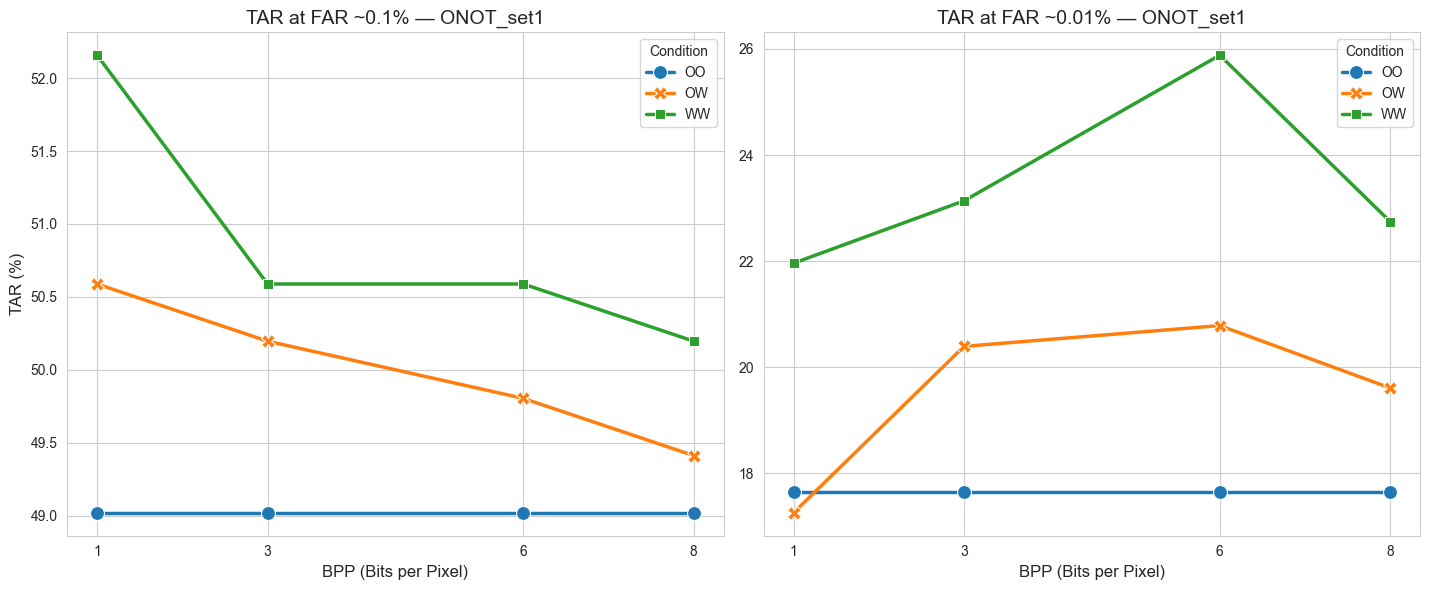

In [100]:
dataset = 'ONOT_set1' # O el dataset que quieras, por ejemplo 'CFD'
fars = [0.001, 0.0001] 

# Generar los plots
plot_tar_vs_bpp_subplots(
    df_long=df_long, # Cambiar a tu df_long REAL
    threshold_dict=results, 
    dataset_name=dataset, 
    far_list=fars
)

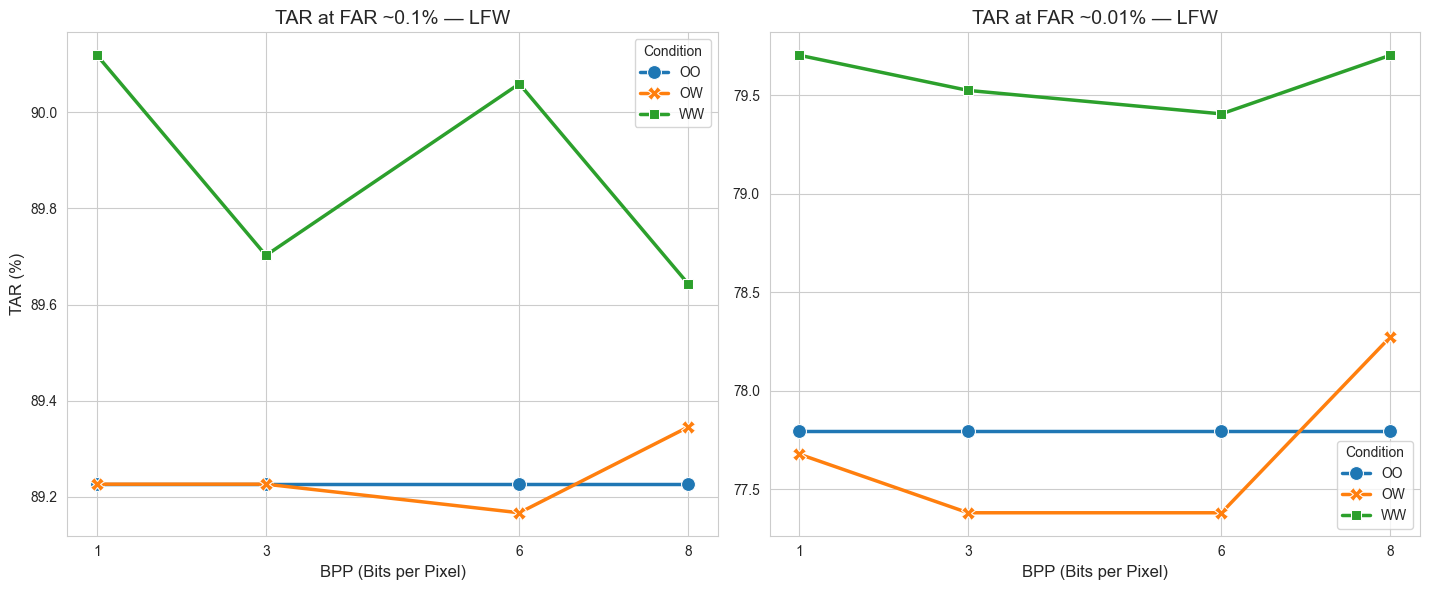

In [101]:
dataset = 'LFW' # O el dataset que quieras, por ejemplo 'CFD'
fars = [0.001, 0.0001] 

# Generar los plots
plot_tar_vs_bpp_subplots(
    df_long=df_long, # Cambiar a tu df_long REAL
    threshold_dict=results, 
    dataset_name=dataset, 
    far_list=fars
)

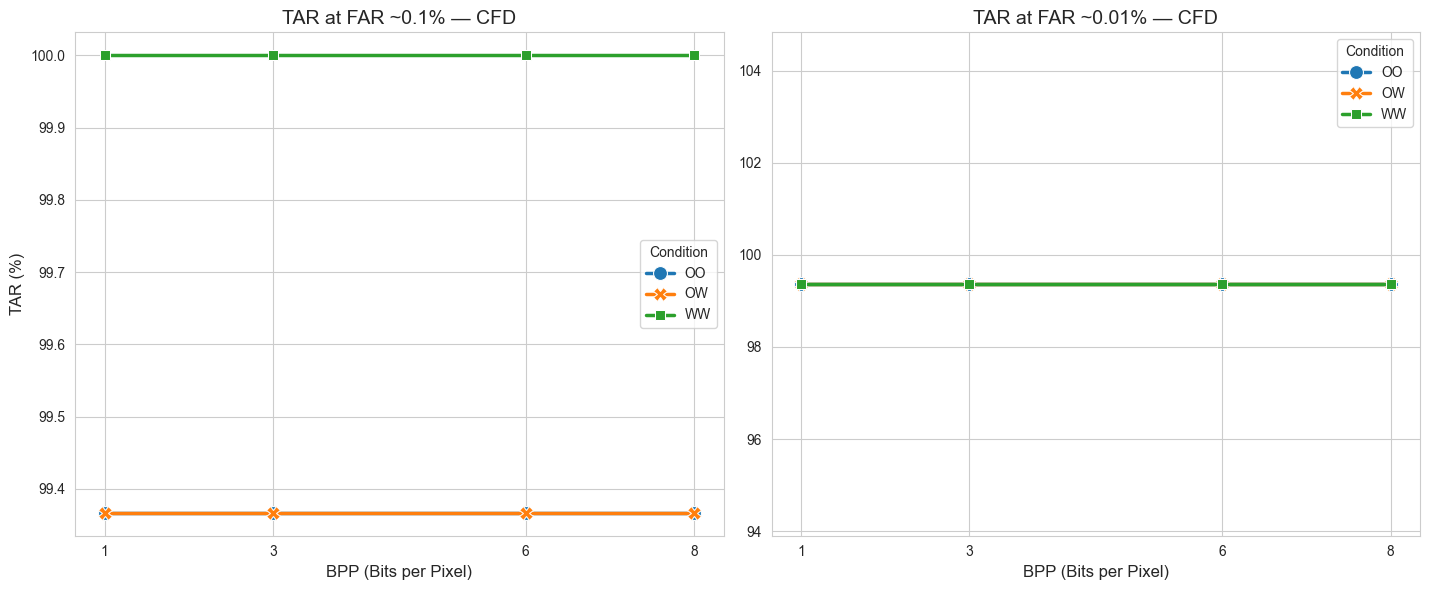

In [106]:
dataset = 'CFD' # O el dataset que quieras, por ejemplo 'CFD'
fars = [0.001, 0.0001] 

# Generar los plots
plot_tar_vs_bpp_subplots(
    df_long=df_long, # Cambiar a tu df_long REAL
    threshold_dict=results, 
    dataset_name=dataset, 
    far_list=fars
)

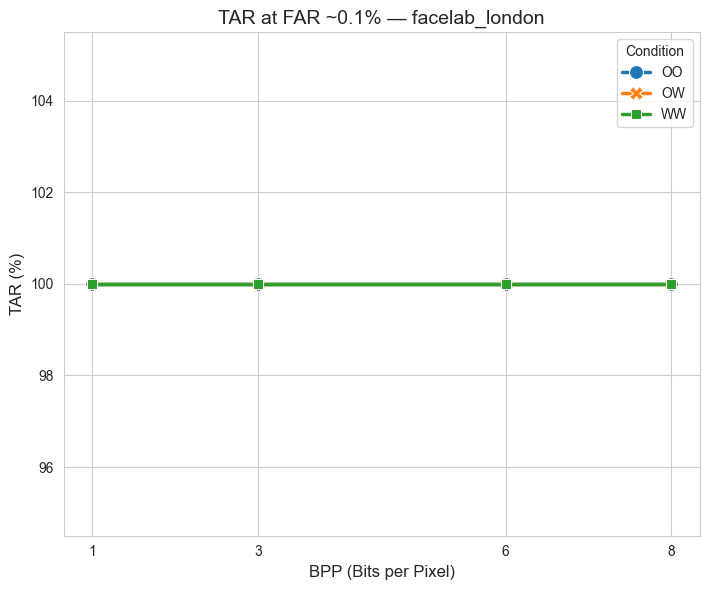

In [109]:
dataset = 'facelab_london' # O el dataset que quieras, por ejemplo 'CFD'
fars = [0.001] 

# Generar los plots
plot_tar_vs_bpp_subplots(
    df_long=df_long, # Cambiar a tu df_long REAL
    threshold_dict=results, 
    dataset_name=dataset, 
    far_list=fars
)

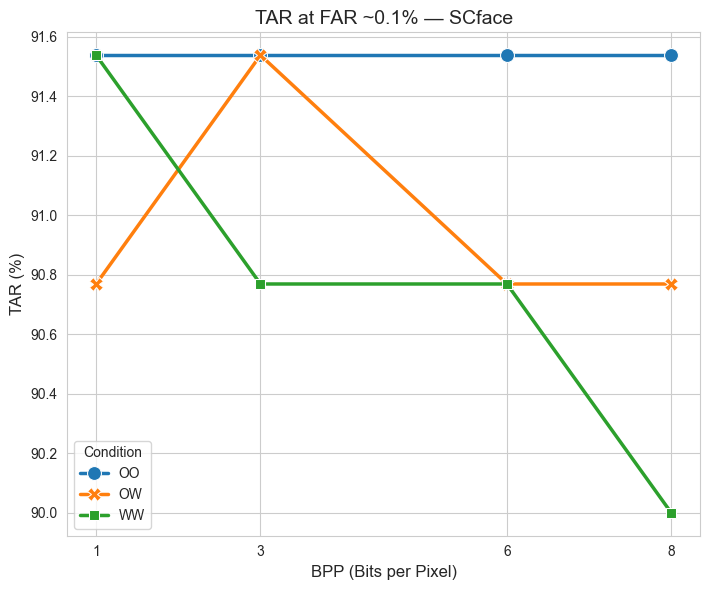

In [107]:
dataset = 'SCface' # O el dataset que quieras, por ejemplo 'CFD'
fars = [0.001] 

# Generar los plots
plot_tar_vs_bpp_subplots(
    df_long=df_long, # Cambiar a tu df_long REAL
    threshold_dict=results, 
    dataset_name=dataset, 
    far_list=fars
)

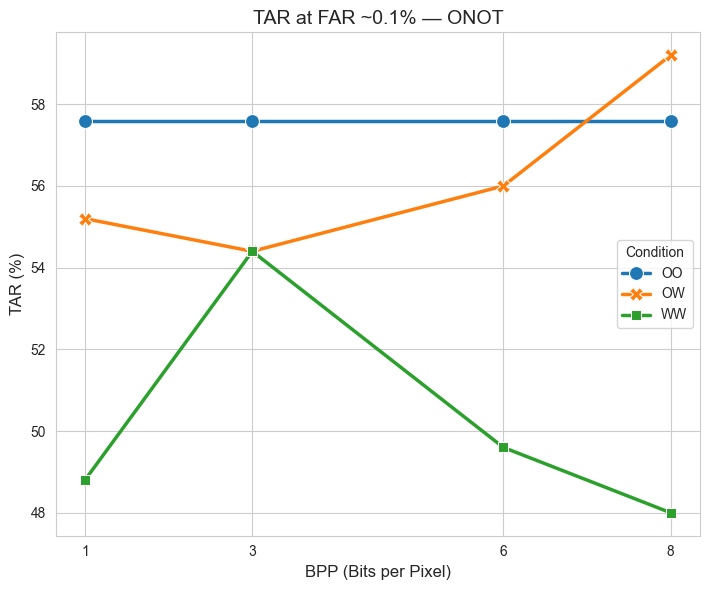

In [108]:
dataset = 'ONOT' # O el dataset que quieras, por ejemplo 'CFD'
fars = [0.001] 

# Generar los plots
plot_tar_vs_bpp_subplots(
    df_long=df_long, # Cambiar a tu df_long REAL
    threshold_dict=results, 
    dataset_name=dataset, 
    far_list=fars
)

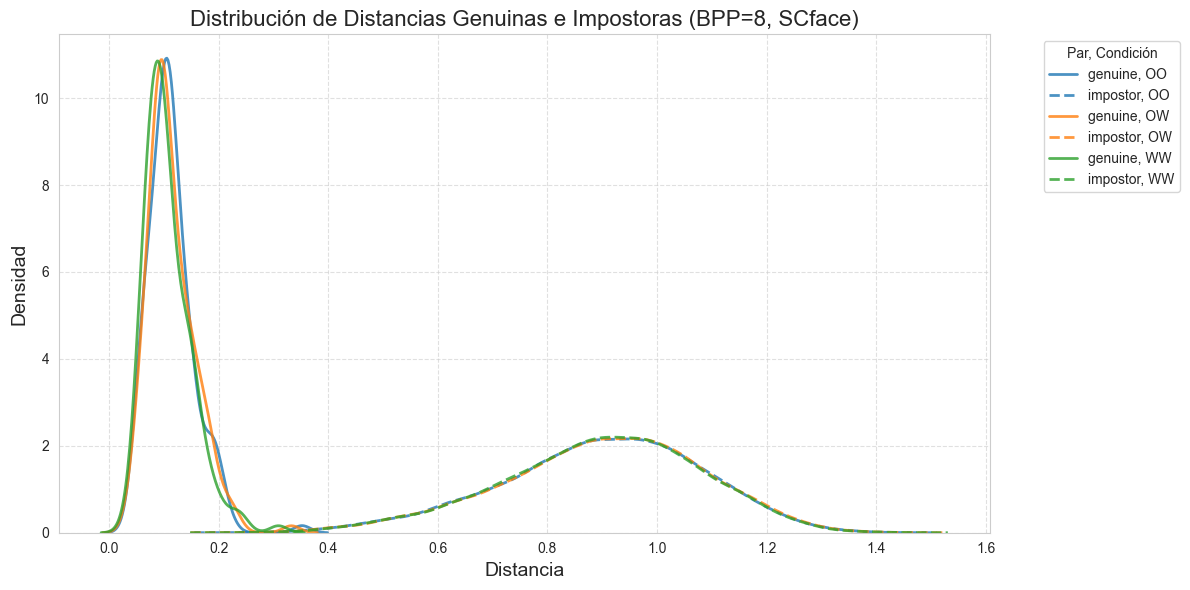

In [131]:
# 1. Filtrar el DataFrame y crear la columna combinada
temp = df_long[
    (df_long.test_dataset == 'CFD') &
    (df_long.bpp == 8)
].copy() 

# --- Crear columna combinada ---
if 'Pair_Condition' not in temp.columns:
    temp['Pair_Condition'] = temp['pair_type'].astype(str).str.strip() + ', ' + temp['condition'].astype(str).str.strip()

# 2. Configurar estilo
plt.figure(figsize=(12, 6))

# --- Definir colores por condición ---
palette = {
    'OO': '#1f77b4',  # azul
    'OW': '#ff7f0e',  # naranja
    'WW': '#2ca02c'   # verde
}

# --- Definir estilos de línea ---
linestyles = {
    'genuine': 'solid',
    'impostor': 'dashed'
}

# 3. Graficar manualmente cada combinación
for cond, color in palette.items():
    for pair, style in linestyles.items():
        subset = temp[
            (temp['condition'] == cond) &
            (temp['pair_type'] == pair)
        ]
        if not subset.empty:
            sns.kdeplot(
                data=subset,
                x='distance',
                color=color,
                linestyle=style,
                linewidth=2,
                label=f'{pair}, {cond}',
                alpha=0.8,
                #common_norm=True,
                #common_grid=True
            )

# 4. Leyenda (sin warning)
handles, labels = plt.gca().get_legend_handles_labels()
if handles and labels:
    plt.legend(
        handles=handles,
        labels=labels,
        title='Par, Condición',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        frameon=True
    )

# 5. Ejes y título
plt.title('Distribución de Distancias Genuinas e Impostoras (BPP=8, SCface)', fontsize=16)
plt.xlabel('Distancia', fontsize=14)
plt.ylabel('Densidad', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [10]:
def compute_group_stats(df_long: pd.DataFrame) -> pd.DataFrame:
    group_cols = ["watermark","recognizer","metric","train_dataset","test_dataset","bpp","condition","pair_type"]
    agg = (
        df_long
        .groupby(group_cols)
        .agg(
            mean_dist=("distance","mean"),
            std_dist=("distance","std"),
            p95=("distance", lambda x: x.quantile(0.95)),
            p99=("distance", lambda x: x.quantile(0.99)),
            p999=("distance", lambda x: x.quantile(0.999)),
            p9999=("distance", lambda x: x.quantile(0.9999)),
            p05=("distance", lambda x: x.quantile(0.05)),
            p01=("distance", lambda x: x.quantile(0.01)),
            p001=("distance", lambda x: x.quantile(0.001)),
            p0001=("distance", lambda x: x.quantile(0.0001)),
            n=("distance","count"),
        )
        .reset_index()
    )
    return agg

In [11]:
# 2) Compute stats
stats = compute_group_stats(df_long)

In [12]:
genuine_cols = ['train_dataset','test_dataset','bpp','condition','pair_type','mean_dist','std_dist', 'p95', 'p99','p999','p9999','n']
impostor_cols = ['train_dataset','test_dataset','bpp','condition','pair_type','mean_dist','std_dist', 'p05', 'p01','p001','p0001','n']

In [13]:
stats

,watermark,recognizer,metric,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p95,p99,p999,p9999,p05,p01,p001,p0001,n
0,stegaformer,facenet,cosine,celeba_hq,CFD,1,OO,genuine,0.113694,0.042561,0.190967,0.215326,0.331412,0.350151,0.056833,0.050048,0.041411,0.040166,158
1,stegaformer,facenet,cosine,celeba_hq,CFD,1,OO,impostor,0.898125,0.183686,1.180110,1.273729,1.363606,1.422391,0.571624,0.437966,0.320698,0.256474,12403
2,stegaformer,facenet,cosine,celeba_hq,CFD,1,OW,genuine,0.114159,0.044304,0.195141,0.223631,0.316843,0.332317,0.056212,0.048771,0.036386,0.034355,158
3,stegaformer,facenet,cosine,celeba_hq,CFD,1,OW,impostor,0.899553,0.183733,1.183564,1.276957,1.369225,1.436992,0.568500,0.433605,0.320980,0.245567,12403
4,stegaformer,facenet,cosine,celeba_hq,CFD,1,WW,genuine,0.107272,0.043004,0.185297,0.225966,0.304526,0.315313,0.055955,0.046745,0.038337,0.037241,158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,stegaformer,facenet,cosine,celeba_hq,facelab_london,8,OO,impostor,0.948671,0.155977,1.197416,1.294279,1.410789,1.489255,0.684163,0.571291,0.441299,0.280514,5151
140,stegaformer,facenet,cosine,celeba_hq,facelab_london,8,OW,genuine,0.072206,0.038497,0.138221,0.206373,0.222980,0.224648,0.028941,0.025886,0.014871,0.013760,102
141,stegaformer,facenet,cosine,celeba_hq,facelab_london,8,OW,impostor,0.950305,0.155543,1.197858,1.296863,1.395926,1.480662,0.684734,0.561731,0.452628,0.306988,5151
142,stegaformer,facenet,cosine,celeba_hq,facelab_london,8,WW,genuine,0.063086,0.035314,0.121332,0.185029,0.207778,0.210048,0.024200,0.016387,0.011863,0.011408,102


In [14]:
stats[(stats['test_dataset']=='ONOT')&(stats['pair_type']=='genuine')][genuine_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p95,p99,p999,p9999,n
48,celeba_hq,ONOT,1,OO,genuine,0.236858,0.095662,0.416879,0.449543,0.500390,0.506856,125
50,celeba_hq,ONOT,1,OW,genuine,0.236329,0.094369,0.399856,0.472604,0.514147,0.518248,125
52,celeba_hq,ONOT,1,WW,genuine,0.231900,0.090874,0.391135,0.436216,0.512229,0.520894,125
54,celeba_hq,ONOT,3,OO,genuine,0.236858,0.095662,0.416879,0.449543,0.500390,0.506856,125
56,celeba_hq,ONOT,3,OW,genuine,0.236275,0.094549,0.401129,0.474279,0.522573,0.527592,125
58,celeba_hq,ONOT,3,WW,genuine,0.232570,0.090555,0.402975,0.423383,0.503400,0.513353,125
60,celeba_hq,ONOT,6,OO,genuine,0.236858,0.095662,0.416879,0.449543,0.500390,0.506856,125
62,celeba_hq,ONOT,6,OW,genuine,0.234796,0.092806,0.407704,0.455732,0.520052,0.527463,125
64,celeba_hq,ONOT,6,WW,genuine,0.231362,0.088583,0.376203,0.406627,0.508035,0.520715,125
66,celeba_hq,ONOT,8,OO,genuine,0.236858,0.095662,0.416879,0.449543,0.500390,0.506856,125


In [15]:
stats[(stats['test_dataset']=='ONOT_set1')&(stats['pair_type']=='genuine')][genuine_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p95,p99,p999,p9999,n
72,celeba_hq,ONOT_set1,1,OO,genuine,0.212546,0.078553,0.361854,0.413709,0.514682,0.519208,255
74,celeba_hq,ONOT_set1,1,OW,genuine,0.213421,0.078691,0.350175,0.419354,0.515888,0.523413,255
76,celeba_hq,ONOT_set1,1,WW,genuine,0.213194,0.079755,0.360748,0.429468,0.513914,0.518933,255
78,celeba_hq,ONOT_set1,3,OO,genuine,0.212546,0.078553,0.361854,0.413709,0.514682,0.519208,255
80,celeba_hq,ONOT_set1,3,OW,genuine,0.214196,0.077702,0.350650,0.414888,0.506588,0.511350,255
82,celeba_hq,ONOT_set1,3,WW,genuine,0.214545,0.078786,0.352256,0.421857,0.512489,0.520870,255
84,celeba_hq,ONOT_set1,6,OO,genuine,0.212546,0.078553,0.361854,0.413709,0.514682,0.519208,255
86,celeba_hq,ONOT_set1,6,OW,genuine,0.213981,0.078793,0.359473,0.428720,0.512955,0.513775,255
88,celeba_hq,ONOT_set1,6,WW,genuine,0.213650,0.080709,0.365847,0.425285,0.528531,0.537303,255
90,celeba_hq,ONOT_set1,8,OO,genuine,0.212546,0.078553,0.361854,0.413709,0.514682,0.519208,255


In [16]:
stats[(stats['test_dataset']=='SCface')&(stats['pair_type']=='genuine')][genuine_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p95,p99,p999,p9999,n
96,celeba_hq,SCface,1,OO,genuine,0.334122,0.108138,0.530384,0.570219,0.844374,0.880824,130
98,celeba_hq,SCface,1,OW,genuine,0.326910,0.107859,0.516294,0.561703,0.803571,0.835676,130
100,celeba_hq,SCface,1,WW,genuine,0.325876,0.107133,0.509222,0.564000,0.821376,0.855039,130
102,celeba_hq,SCface,3,OO,genuine,0.334122,0.108138,0.530384,0.570219,0.844374,0.880824,130
104,celeba_hq,SCface,3,OW,genuine,0.326680,0.107906,0.507834,0.566803,0.811097,0.843294,130
106,celeba_hq,SCface,3,WW,genuine,0.324597,0.106209,0.499644,0.562181,0.801908,0.833269,130
108,celeba_hq,SCface,6,OO,genuine,0.334122,0.108138,0.530384,0.570219,0.844374,0.880824,130
110,celeba_hq,SCface,6,OW,genuine,0.324778,0.107728,0.510597,0.556618,0.811137,0.844858,130
112,celeba_hq,SCface,6,WW,genuine,0.323868,0.107273,0.499290,0.555319,0.810090,0.843667,130
114,celeba_hq,SCface,8,OO,genuine,0.334122,0.108138,0.530384,0.570219,0.844374,0.880824,130


In [17]:
stats[(stats['test_dataset']=='LFW')&(stats['pair_type']=='genuine')][genuine_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p95,p99,p999,p9999,n
24,celeba_hq,LFW,1,OO,genuine,0.275788,0.185740,0.589933,1.059769,1.246686,1.284549,1680
26,celeba_hq,LFW,1,OW,genuine,0.285847,0.189733,0.642906,1.078706,1.256396,1.298926,1680
28,celeba_hq,LFW,1,WW,genuine,0.277712,0.190841,0.654289,1.079062,1.280008,1.282858,1680
30,celeba_hq,LFW,3,OO,genuine,0.275788,0.185740,0.589933,1.059769,1.246686,1.284549,1680
32,celeba_hq,LFW,3,OW,genuine,0.285528,0.189141,0.640487,1.078251,1.257064,1.299958,1680
34,celeba_hq,LFW,3,WW,genuine,0.278317,0.192504,0.674355,1.096839,1.280404,1.284106,1680
36,celeba_hq,LFW,6,OO,genuine,0.275788,0.185740,0.589933,1.059769,1.246686,1.284549,1680
38,celeba_hq,LFW,6,OW,genuine,0.285772,0.189601,0.643410,1.076576,1.258094,1.294939,1680
40,celeba_hq,LFW,6,WW,genuine,0.279421,0.193953,0.693626,1.100081,1.282303,1.294391,1680
42,celeba_hq,LFW,8,OO,genuine,0.275788,0.185740,0.589933,1.059769,1.246686,1.284549,1680


In [18]:
stats[(stats['test_dataset']=='CFD')&(stats['pair_type']=='genuine')][genuine_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p95,p99,p999,p9999,n
0,celeba_hq,CFD,1,OO,genuine,0.113694,0.042561,0.190967,0.215326,0.331412,0.350151,158
2,celeba_hq,CFD,1,OW,genuine,0.114159,0.044304,0.195141,0.223631,0.316843,0.332317,158
4,celeba_hq,CFD,1,WW,genuine,0.107272,0.043004,0.185297,0.225966,0.304526,0.315313,158
6,celeba_hq,CFD,3,OO,genuine,0.113694,0.042561,0.190967,0.215326,0.331412,0.350151,158
8,celeba_hq,CFD,3,OW,genuine,0.114484,0.044236,0.195175,0.223948,0.316015,0.331336,158
10,celeba_hq,CFD,3,WW,genuine,0.107756,0.042868,0.182189,0.224898,0.294758,0.304548,158
12,celeba_hq,CFD,6,OO,genuine,0.113694,0.042561,0.190967,0.215326,0.331412,0.350151,158
14,celeba_hq,CFD,6,OW,genuine,0.115786,0.044526,0.188543,0.229682,0.317429,0.331216,158
16,celeba_hq,CFD,6,WW,genuine,0.109365,0.043356,0.185939,0.232918,0.295106,0.305460,158
18,celeba_hq,CFD,8,OO,genuine,0.113694,0.042561,0.190967,0.215326,0.331412,0.350151,158


In [19]:
stats[(stats['test_dataset']=='facelab_london')&(stats['pair_type']=='genuine')][genuine_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p95,p99,p999,p9999,n
120,celeba_hq,facelab_london,1,OO,genuine,0.074055,0.039585,0.147272,0.204413,0.210092,0.210660,102
122,celeba_hq,facelab_london,1,OW,genuine,0.070917,0.037584,0.137591,0.198229,0.209475,0.210601,102
124,celeba_hq,facelab_london,1,WW,genuine,0.061252,0.035381,0.120990,0.170495,0.191398,0.193500,102
126,celeba_hq,facelab_london,3,OO,genuine,0.074055,0.039585,0.147272,0.204413,0.210092,0.210660,102
128,celeba_hq,facelab_london,3,OW,genuine,0.071361,0.037259,0.136838,0.197734,0.205797,0.206596,102
130,celeba_hq,facelab_london,3,WW,genuine,0.061222,0.035566,0.118704,0.182119,0.193054,0.194155,102
132,celeba_hq,facelab_london,6,OO,genuine,0.074055,0.039585,0.147272,0.204413,0.210092,0.210660,102
134,celeba_hq,facelab_london,6,OW,genuine,0.071785,0.037250,0.137395,0.195467,0.219904,0.222369,102
136,celeba_hq,facelab_london,6,WW,genuine,0.061190,0.033714,0.121095,0.166681,0.201909,0.205447,102
138,celeba_hq,facelab_london,8,OO,genuine,0.074055,0.039585,0.147272,0.204413,0.210092,0.210660,102


## IMPOSTOR

In [20]:
stats[(stats['test_dataset']=='ONOT')&(stats['pair_type']=='impostor')][impostor_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p05,p01,p001,p0001,n
49,celeba_hq,ONOT,1,OO,impostor,0.835483,0.194504,0.488002,0.335757,0.230193,0.161458,7750
51,celeba_hq,ONOT,1,OW,impostor,0.832966,0.194066,0.484172,0.336176,0.235910,0.167497,7750
53,celeba_hq,ONOT,1,WW,impostor,0.832642,0.194040,0.488377,0.338368,0.219737,0.174004,7750
55,celeba_hq,ONOT,3,OO,impostor,0.835483,0.194504,0.488002,0.335757,0.230193,0.161458,7750
57,celeba_hq,ONOT,3,OW,impostor,0.832370,0.194404,0.485547,0.338573,0.231195,0.168426,7750
59,celeba_hq,ONOT,3,WW,impostor,0.832923,0.194573,0.488198,0.339588,0.227069,0.176812,7750
61,celeba_hq,ONOT,6,OO,impostor,0.835483,0.194504,0.488002,0.335757,0.230193,0.161458,7750
63,celeba_hq,ONOT,6,OW,impostor,0.832142,0.194601,0.480797,0.332602,0.231113,0.158609,7750
65,celeba_hq,ONOT,6,WW,impostor,0.831846,0.193959,0.486874,0.336222,0.218270,0.152017,7750
67,celeba_hq,ONOT,8,OO,impostor,0.835483,0.194504,0.488002,0.335757,0.230193,0.161458,7750


In [21]:
stats[(stats['test_dataset']=='ONOT_set1')&(stats['pair_type']=='impostor')][impostor_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p05,p01,p001,p0001,n
73,celeba_hq,ONOT_set1,1,OO,impostor,0.811994,0.198591,0.451663,0.312263,0.202968,0.141515,32385
75,celeba_hq,ONOT_set1,1,OW,impostor,0.811079,0.198530,0.450654,0.310097,0.203297,0.144800,32385
77,celeba_hq,ONOT_set1,1,WW,impostor,0.811145,0.197786,0.454910,0.310681,0.208482,0.150150,32385
79,celeba_hq,ONOT_set1,3,OO,impostor,0.811994,0.198591,0.451663,0.312263,0.202968,0.141515,32385
81,celeba_hq,ONOT_set1,3,OW,impostor,0.811229,0.198346,0.452107,0.310390,0.205127,0.149623,32385
83,celeba_hq,ONOT_set1,3,WW,impostor,0.811825,0.197471,0.456668,0.312863,0.206962,0.151828,32385
85,celeba_hq,ONOT_set1,6,OO,impostor,0.811994,0.198591,0.451663,0.312263,0.202968,0.141515,32385
87,celeba_hq,ONOT_set1,6,OW,impostor,0.811486,0.198255,0.452351,0.312473,0.205629,0.147435,32385
89,celeba_hq,ONOT_set1,6,WW,impostor,0.810370,0.197746,0.454791,0.310285,0.207117,0.154443,32385
91,celeba_hq,ONOT_set1,8,OO,impostor,0.811994,0.198591,0.451663,0.312263,0.202968,0.141515,32385


In [22]:
stats[(stats['test_dataset']=='SCface')&(stats['pair_type']=='impostor')][impostor_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p05,p01,p001,p0001,n
97,celeba_hq,SCface,1,OO,impostor,0.926698,0.161234,0.658316,0.558632,0.478843,0.385444,8385
99,celeba_hq,SCface,1,OW,impostor,0.927202,0.161885,0.659580,0.558867,0.463637,0.370243,8385
101,celeba_hq,SCface,1,WW,impostor,0.925883,0.161772,0.657975,0.556957,0.464236,0.376783,8385
103,celeba_hq,SCface,3,OO,impostor,0.926698,0.161234,0.658316,0.558632,0.478843,0.385444,8385
105,celeba_hq,SCface,3,OW,impostor,0.926738,0.161352,0.659487,0.559983,0.462700,0.392027,8385
107,celeba_hq,SCface,3,WW,impostor,0.924943,0.161264,0.657322,0.557953,0.456550,0.395484,8385
109,celeba_hq,SCface,6,OO,impostor,0.926698,0.161234,0.658316,0.558632,0.478843,0.385444,8385
111,celeba_hq,SCface,6,OW,impostor,0.926313,0.161158,0.659231,0.559798,0.460017,0.387182,8385
113,celeba_hq,SCface,6,WW,impostor,0.924658,0.161091,0.658690,0.556766,0.455861,0.393078,8385
115,celeba_hq,SCface,8,OO,impostor,0.926698,0.161234,0.658316,0.558632,0.478843,0.385444,8385


In [23]:
stats[(stats['test_dataset']=='LFW')&(stats['pair_type']=='impostor')][impostor_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p05,p01,p001,p0001,n
25,celeba_hq,LFW,1,OO,impostor,0.950712,0.155654,0.687910,0.570294,0.438911,0.337498,1410360
27,celeba_hq,LFW,1,OW,impostor,0.963210,0.155125,0.701054,0.582590,0.449068,0.345270,1410360
29,celeba_hq,LFW,1,WW,impostor,0.965162,0.154706,0.703599,0.584605,0.449174,0.347661,1410360
31,celeba_hq,LFW,3,OO,impostor,0.950712,0.155654,0.687910,0.570294,0.438911,0.337498,1410360
33,celeba_hq,LFW,3,OW,impostor,0.963283,0.155112,0.701278,0.582481,0.449136,0.344792,1410360
35,celeba_hq,LFW,3,WW,impostor,0.965176,0.154679,0.703654,0.584482,0.448746,0.345178,1410360
37,celeba_hq,LFW,6,OO,impostor,0.950712,0.155654,0.687910,0.570294,0.438911,0.337498,1410360
39,celeba_hq,LFW,6,OW,impostor,0.963385,0.155090,0.701118,0.582708,0.448683,0.343955,1410360
41,celeba_hq,LFW,6,WW,impostor,0.965403,0.154594,0.704019,0.585310,0.448836,0.346322,1410360
43,celeba_hq,LFW,8,OO,impostor,0.950712,0.155654,0.687910,0.570294,0.438911,0.337498,1410360


In [24]:
stats[(stats['test_dataset']=='CFD')&(stats['pair_type']=='impostor')][impostor_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p05,p01,p001,p0001,n
1,celeba_hq,CFD,1,OO,impostor,0.898125,0.183686,0.571624,0.437966,0.320698,0.256474,12403
3,celeba_hq,CFD,1,OW,impostor,0.899553,0.183733,0.568500,0.433605,0.320980,0.245567,12403
5,celeba_hq,CFD,1,WW,impostor,0.895518,0.182481,0.566919,0.436570,0.320474,0.260227,12403
7,celeba_hq,CFD,3,OO,impostor,0.898125,0.183686,0.571624,0.437966,0.320698,0.256474,12403
9,celeba_hq,CFD,3,OW,impostor,0.899912,0.183402,0.568950,0.434925,0.320682,0.245337,12403
11,celeba_hq,CFD,3,WW,impostor,0.896588,0.182026,0.571025,0.439896,0.321303,0.259855,12403
13,celeba_hq,CFD,6,OO,impostor,0.898125,0.183686,0.571624,0.437966,0.320698,0.256474,12403
15,celeba_hq,CFD,6,OW,impostor,0.899589,0.183472,0.568401,0.436659,0.319533,0.247466,12403
17,celeba_hq,CFD,6,WW,impostor,0.895915,0.182090,0.568643,0.438093,0.322822,0.271970,12403
19,celeba_hq,CFD,8,OO,impostor,0.898125,0.183686,0.571624,0.437966,0.320698,0.256474,12403


In [25]:
stats[(stats['test_dataset']=='facelab_london')&(stats['pair_type']=='impostor')][impostor_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p05,p01,p001,p0001,n
121,celeba_hq,facelab_london,1,OO,impostor,0.948671,0.155977,0.684163,0.571291,0.441299,0.280514,5151
123,celeba_hq,facelab_london,1,OW,impostor,0.950552,0.155351,0.685230,0.565965,0.458495,0.317819,5151
125,celeba_hq,facelab_london,1,WW,impostor,0.948567,0.155200,0.683855,0.571843,0.457989,0.319349,5151
127,celeba_hq,facelab_london,3,OO,impostor,0.948671,0.155977,0.684163,0.571291,0.441299,0.280514,5151
129,celeba_hq,facelab_london,3,OW,impostor,0.950621,0.155347,0.684550,0.568092,0.459926,0.316709,5151
131,celeba_hq,facelab_london,3,WW,impostor,0.948684,0.155128,0.682893,0.570193,0.455506,0.319791,5151
133,celeba_hq,facelab_london,6,OO,impostor,0.948671,0.155977,0.684163,0.571291,0.441299,0.280514,5151
135,celeba_hq,facelab_london,6,OW,impostor,0.950390,0.155281,0.682767,0.566876,0.460084,0.314937,5151
137,celeba_hq,facelab_london,6,WW,impostor,0.948719,0.155347,0.680819,0.570344,0.454190,0.316429,5151
139,celeba_hq,facelab_london,8,OO,impostor,0.948671,0.155977,0.684163,0.571291,0.441299,0.280514,5151


### variacion stadisticas ONOT genuine

In [23]:
baseline = stats[stats['condition'] == 'OO'][["watermark",'train_dataset','test_dataset','pair_type','bpp','mean_dist','std_dist','p99','p999','p9999','p01','p001','p0001']]
baseline

,watermark,train_dataset,test_dataset,pair_type,bpp,mean_dist,std_dist,p99,p999,p9999,p01,p001,p0001
0,stegaformer,coco,CFD,genuine,1,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
1,stegaformer,coco,CFD,impostor,1,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474
6,stegaformer,coco,CFD,genuine,3,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
7,stegaformer,coco,CFD,impostor,3,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474
12,stegaformer,coco,CFD,genuine,6,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
13,stegaformer,coco,CFD,impostor,6,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474
18,stegaformer,coco,CFD,genuine,8,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
19,stegaformer,coco,CFD,impostor,8,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474
24,stegaformer,coco,LFW,genuine,1,0.275788,0.185740,0.589933,1.246686,1.284549,0.066335,0.036852,0.034126
25,stegaformer,coco,LFW,impostor,1,0.950712,0.155654,1.200284,1.399936,1.478828,0.570294,0.438911,0.337498


In [24]:
merged = stats.merge(baseline, on=["watermark",'train_dataset','test_dataset','pair_type','bpp'], suffixes=('', '_base'))
merged

,watermark,recognizer,metric,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,...,p0001,n,mean_dist_base,std_dist_base,p99_base,p999_base,p9999_base,p01_base,p001_base,p0001_base
0,stegaformer,facenet,cosine,coco,CFD,1,OO,genuine,0.113694,0.042561,...,0.040166,158,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
1,stegaformer,facenet,cosine,coco,CFD,1,OO,impostor,0.898125,0.183686,...,0.256474,12403,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474
2,stegaformer,facenet,cosine,coco,CFD,1,OW,genuine,0.114248,0.044573,...,0.034349,158,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
3,stegaformer,facenet,cosine,coco,CFD,1,OW,impostor,0.899789,0.183556,...,0.245387,12403,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474
4,stegaformer,facenet,cosine,coco,CFD,1,WW,genuine,0.107636,0.043260,...,0.035010,158,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,stegaformer,facenet,cosine,coco,facelab_london,8,OO,impostor,0.948671,0.155977,...,0.280514,5151,0.948671,0.155977,1.197416,1.410789,1.489255,0.571291,0.441299,0.280514
92,stegaformer,facenet,cosine,coco,facelab_london,8,OW,genuine,0.071355,0.036964,...,0.013518,102,0.074055,0.039585,0.147272,0.210092,0.210660,0.021719,0.014959,0.014277
93,stegaformer,facenet,cosine,coco,facelab_london,8,OW,impostor,0.950783,0.155426,...,0.309880,5151,0.948671,0.155977,1.197416,1.410789,1.489255,0.571291,0.441299,0.280514
94,stegaformer,facenet,cosine,coco,facelab_london,8,WW,genuine,0.060376,0.033636,...,0.011506,102,0.074055,0.039585,0.147272,0.210092,0.210660,0.021719,0.014959,0.014277


In [25]:
merged['Δmean'] = merged['mean_dist'] - merged['mean_dist_base']
merged['Δstd']  = merged['std_dist'] - merged['std_dist_base']
merged['Δp99.9']  = merged['p999'] - merged['p999_base']

merged

,watermark,recognizer,metric,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,...,std_dist_base,p99_base,p999_base,p9999_base,p01_base,p001_base,p0001_base,Δmean,Δstd,Δp99.9
0,stegaformer,facenet,cosine,coco,CFD,1,OO,genuine,0.113694,0.042561,...,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166,0.000000,0.000000,0.000000
1,stegaformer,facenet,cosine,coco,CFD,1,OO,impostor,0.898125,0.183686,...,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474,0.000000,0.000000,0.000000
2,stegaformer,facenet,cosine,coco,CFD,1,OW,genuine,0.114248,0.044573,...,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166,0.000554,0.002012,-0.013637
3,stegaformer,facenet,cosine,coco,CFD,1,OW,impostor,0.899789,0.183556,...,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474,0.001664,-0.000130,0.007449
4,stegaformer,facenet,cosine,coco,CFD,1,WW,genuine,0.107636,0.043260,...,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166,-0.006057,0.000700,-0.025235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,stegaformer,facenet,cosine,coco,facelab_london,8,OO,impostor,0.948671,0.155977,...,0.155977,1.197416,1.410789,1.489255,0.571291,0.441299,0.280514,0.000000,0.000000,0.000000
92,stegaformer,facenet,cosine,coco,facelab_london,8,OW,genuine,0.071355,0.036964,...,0.039585,0.147272,0.210092,0.210660,0.021719,0.014959,0.014277,-0.002700,-0.002622,0.005865
93,stegaformer,facenet,cosine,coco,facelab_london,8,OW,impostor,0.950783,0.155426,...,0.155977,1.197416,1.410789,1.489255,0.571291,0.441299,0.280514,0.002112,-0.000551,-0.016172
94,stegaformer,facenet,cosine,coco,facelab_london,8,WW,genuine,0.060376,0.033636,...,0.039585,0.147272,0.210092,0.210660,0.021719,0.014959,0.014277,-0.013679,-0.005950,-0.010416


In [27]:
merged[(merged['test_dataset']=='ONOT') & (merged['pair_type']=='genuine')]

,watermark,recognizer,metric,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,...,std_dist_base,p99_base,p999_base,p9999_base,p01_base,p001_base,p0001_base,Δmean,Δstd,Δp99.9
48,stegaformer,facenet,cosine,coco,ONOT,1,OO,genuine,0.236858,0.095662,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,0.000000,0.000000,0.000000
50,stegaformer,facenet,cosine,coco,ONOT,1,OW,genuine,0.236197,0.095944,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,-0.000662,0.000282,0.014208
52,stegaformer,facenet,cosine,coco,ONOT,1,WW,genuine,0.232929,0.092273,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,-0.003929,-0.003389,0.011394
54,stegaformer,facenet,cosine,coco,ONOT,3,OO,genuine,0.236858,0.095662,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,0.000000,0.000000,0.000000
56,stegaformer,facenet,cosine,coco,ONOT,3,OW,genuine,0.236215,0.095291,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,-0.000643,-0.000371,0.014046
58,stegaformer,facenet,cosine,coco,ONOT,3,WW,genuine,0.233330,0.092629,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,-0.003528,-0.003033,0.039281
60,stegaformer,facenet,cosine,coco,ONOT,6,OO,genuine,0.236858,0.095662,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,0.000000,0.000000,0.000000
62,stegaformer,facenet,cosine,coco,ONOT,6,OW,genuine,0.236601,0.095191,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,-0.000257,-0.000471,0.027098
64,stegaformer,facenet,cosine,coco,ONOT,6,WW,genuine,0.233711,0.092307,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,-0.003147,-0.003355,0.047312
66,stegaformer,facenet,cosine,coco,ONOT,8,OO,genuine,0.236858,0.095662,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,0.000000,0.000000,0.000000


### graficas

In [28]:
df_long.head()

,watermark,recognizer,metric,train_dataset,test_dataset,bpp,condition,pair_type,distance,experiment,path
0,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.109063,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
1,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.081616,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
2,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.219615,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
3,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.070410,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
4,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.104042,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...


In [ ]:
sns.boxplot(data=df_long[(df_long.test_dataset=='ONOT')&(df_long.pair_type=='genuine')], x='bpp', y='distance', hue='condition')

<Axes: xlabel='bpp', ylabel='distance'>

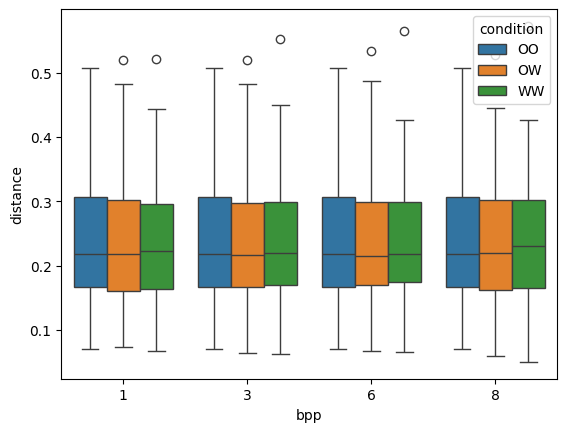

In [30]:
sns.boxplot(data=df_long[(df_long.test_dataset=='ONOT')&(df_long.pair_type=='genuine')], x='bpp', y='distance', hue='condition')

<Axes: xlabel='bpp', ylabel='distance'>

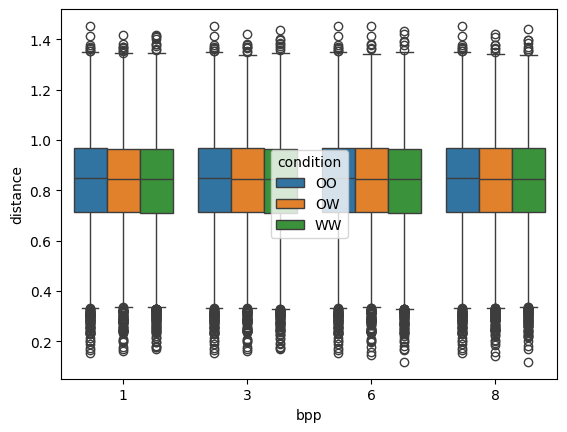

In [31]:
sns.boxplot(data=df_long[(df_long.test_dataset=='ONOT')&(df_long.pair_type=='impostor')], x='bpp', y='distance', hue='condition')

<Axes: xlabel='distance', ylabel='Density'>

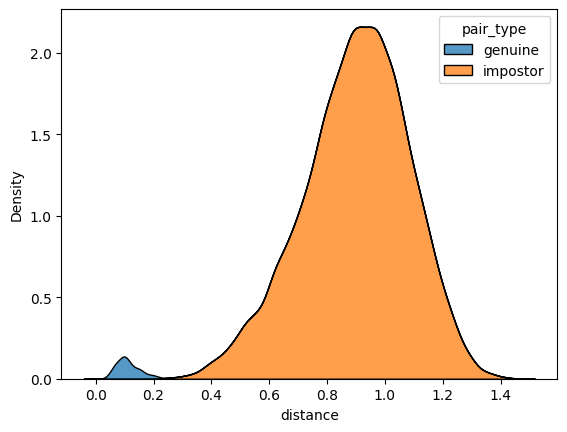

In [33]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='CFD') & (df_long.bpp==8)],
            x='distance', hue='pair_type', multiple='stack')

<Axes: xlabel='distance', ylabel='Density'>

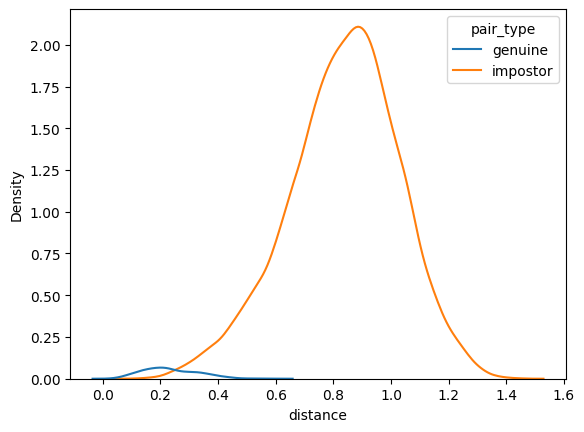

In [59]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='ONOT') & (df_long.bpp==8)],
            x='distance', hue='pair_type', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

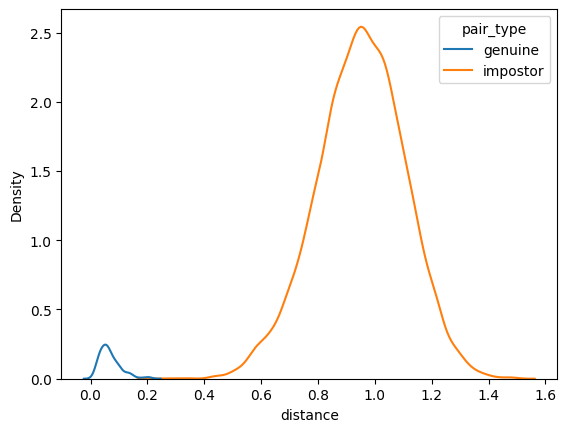

In [52]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='facelab_london') & (df_long.bpp==1)],
            x='distance', hue='pair_type', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

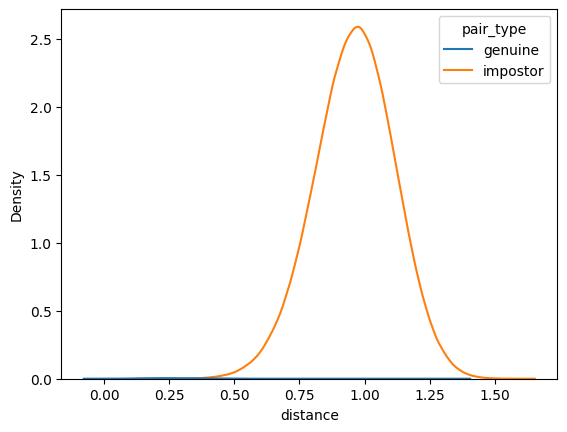

In [51]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='LFW') & (df_long.bpp==1)],
            x='distance', hue='pair_type', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

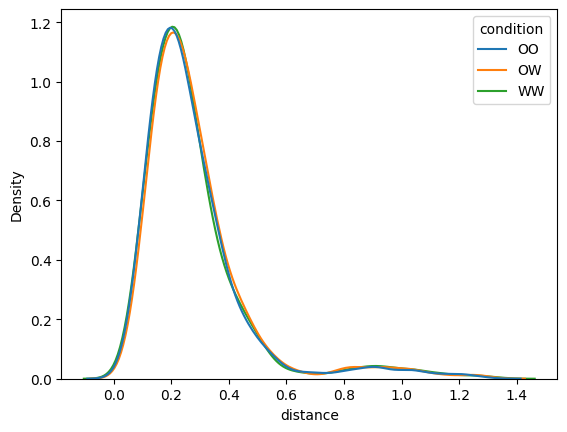

In [49]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='LFW') & (df_long.bpp==8) & (df_long.pair_type=='genuine')],
            x='distance', hue='condition', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

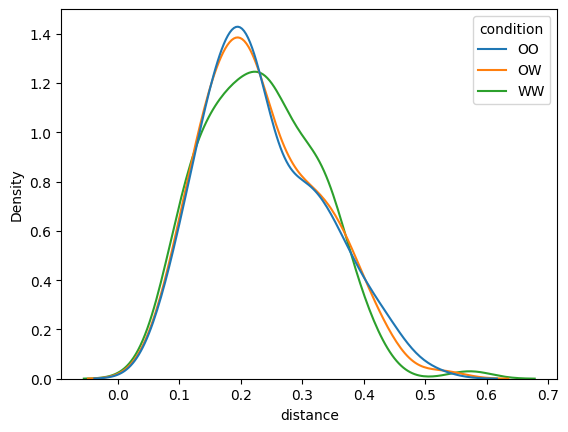

In [65]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='ONOT') & (df_long.bpp==8) & (df_long.pair_type=='genuine')],
            x='distance', hue='condition', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

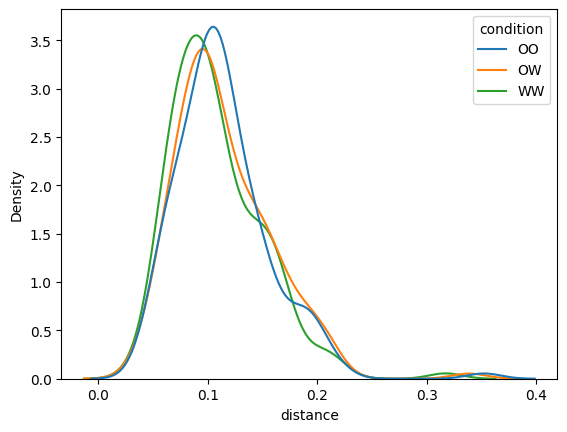

In [64]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='CFD') & (df_long.bpp==8) & (df_long.pair_type=='genuine')],
            x='distance', hue='condition', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

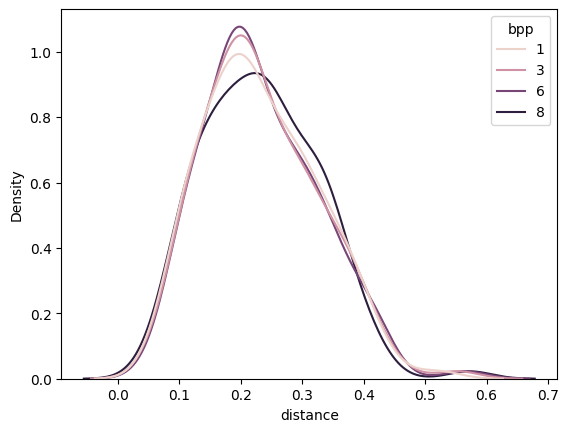

In [55]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='ONOT') & (df_long.pair_type=='genuine') & (df_long.condition=='WW')],
            x='distance', hue='bpp', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

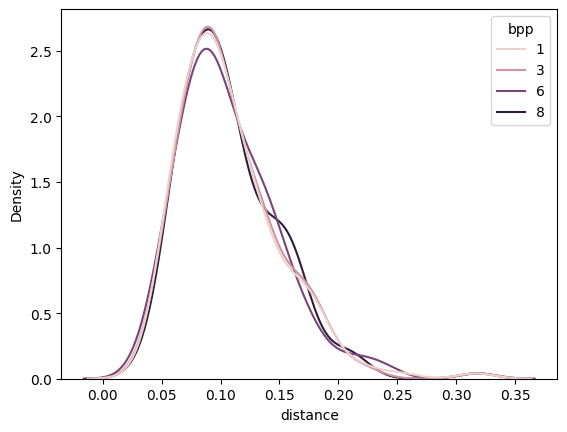

In [66]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='CFD') & (df_long.pair_type=='genuine') & (df_long.condition=='WW')],
            x='distance', hue='bpp', multiple='layer', bw_adjust=1)

In [56]:
import numpy as np
from scipy.stats import gaussian_kde

In [60]:
# Estimar PDFs con KDE

genuine = df_long[(df_long.test_dataset=='ONOT') 
                  & (df_long.bpp==8) 
                  & (df_long.pair_type=='genuine') 
                  & (df_long.condition=='OO')]['distance'].to_numpy()

impostor = df_long[(df_long.test_dataset=='ONOT') 
                   & (df_long.bpp==8)  
                   & (df_long.pair_type=='impostor')
                   & (df_long.condition=='OO')]['distance'].to_numpy()

x = np.linspace(0, 1, 10000)
pdf_g = gaussian_kde(genuine)(x)
pdf_i = gaussian_kde(impostor)(x)

# Calcular el área de solapamiento
overlap = np.trapz(np.minimum(pdf_g, pdf_i), x)
print(f"Overlap: {overlap:.3f}")

Overlap: 0.061


In [61]:
genuine = df_long[(df_long.test_dataset=='ONOT') 
                  & (df_long.bpp==8) 
                  & (df_long.pair_type=='genuine') 
                  & (df_long.condition=='WW')]['distance'].to_numpy()

impostor = df_long[(df_long.test_dataset=='ONOT') 
                   & (df_long.bpp==8)  
                   & (df_long.pair_type=='impostor')
                   & (df_long.condition=='WW')]['distance'].to_numpy()

x = np.linspace(0, 1, 10000)
pdf_g = gaussian_kde(genuine)(x)
pdf_i = gaussian_kde(impostor)(x)

# Calcular el área de solapamiento
overlap = np.trapz(np.minimum(pdf_g, pdf_i), x)
print(f"Overlap: {overlap:.3f}")

Overlap: 0.050


In [ ]:
# impostor threshold para FAR=alpha (alpha=1e-4)
tau = np.quantile(impostor, 0.0001)

# PDFs sobre grilla x
mask = x <= tau
partial_overlap = np.trapz(np.minimum(pdf_g[mask], pdf_i[mask]), x[mask])